In [25]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import seaborn as sns

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import pandas as pd 
from tqdm.notebook import tqdm
import ephem

# Default parameters
fontsize = 16
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [26]:
PTHS = {
    'sar_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_UC_DIAGNOSTIC/01_PLOT_DIAGNOSTIC/'
}

### Open data
dsg  = xr.open_dataset(PTHS['sar_pth'])

In [27]:
# GROUP BY BASIN
dsg['basin_idx'] = dsg.vmx.copy(deep=True) * np.nan
# basin_keys       = np.unique(dsg.basin)
basin_keys       = np.array(['al', 'cp', 'ep', 'wp', 'io', 'sh']) # Same order like Chavas et al 2016
for t in tqdm(range(len(dsg.time))):
    dsg['basin_idx'][t] = np.where(basin_keys == dsg.isel(time=t).basin.item())[0][0] + 1
basin_keys_combined = np.concatenate((['all'], basin_keys))

  0%|          | 0/1666 [00:00<?, ?it/s]

In [28]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

640


In [29]:
# 1) vmx, rmx, fcor, R34/R50/R64 + comparison with best-track data
# 2) B, rossby, Uc, R+, R0, eventually V+ and V0.
# By basin and by t(LMI)

### 1) By basin

/tmp/ipykernel_12096/1202152999.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)
/tmp/ipykernel_12096/1202152999.py:270: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


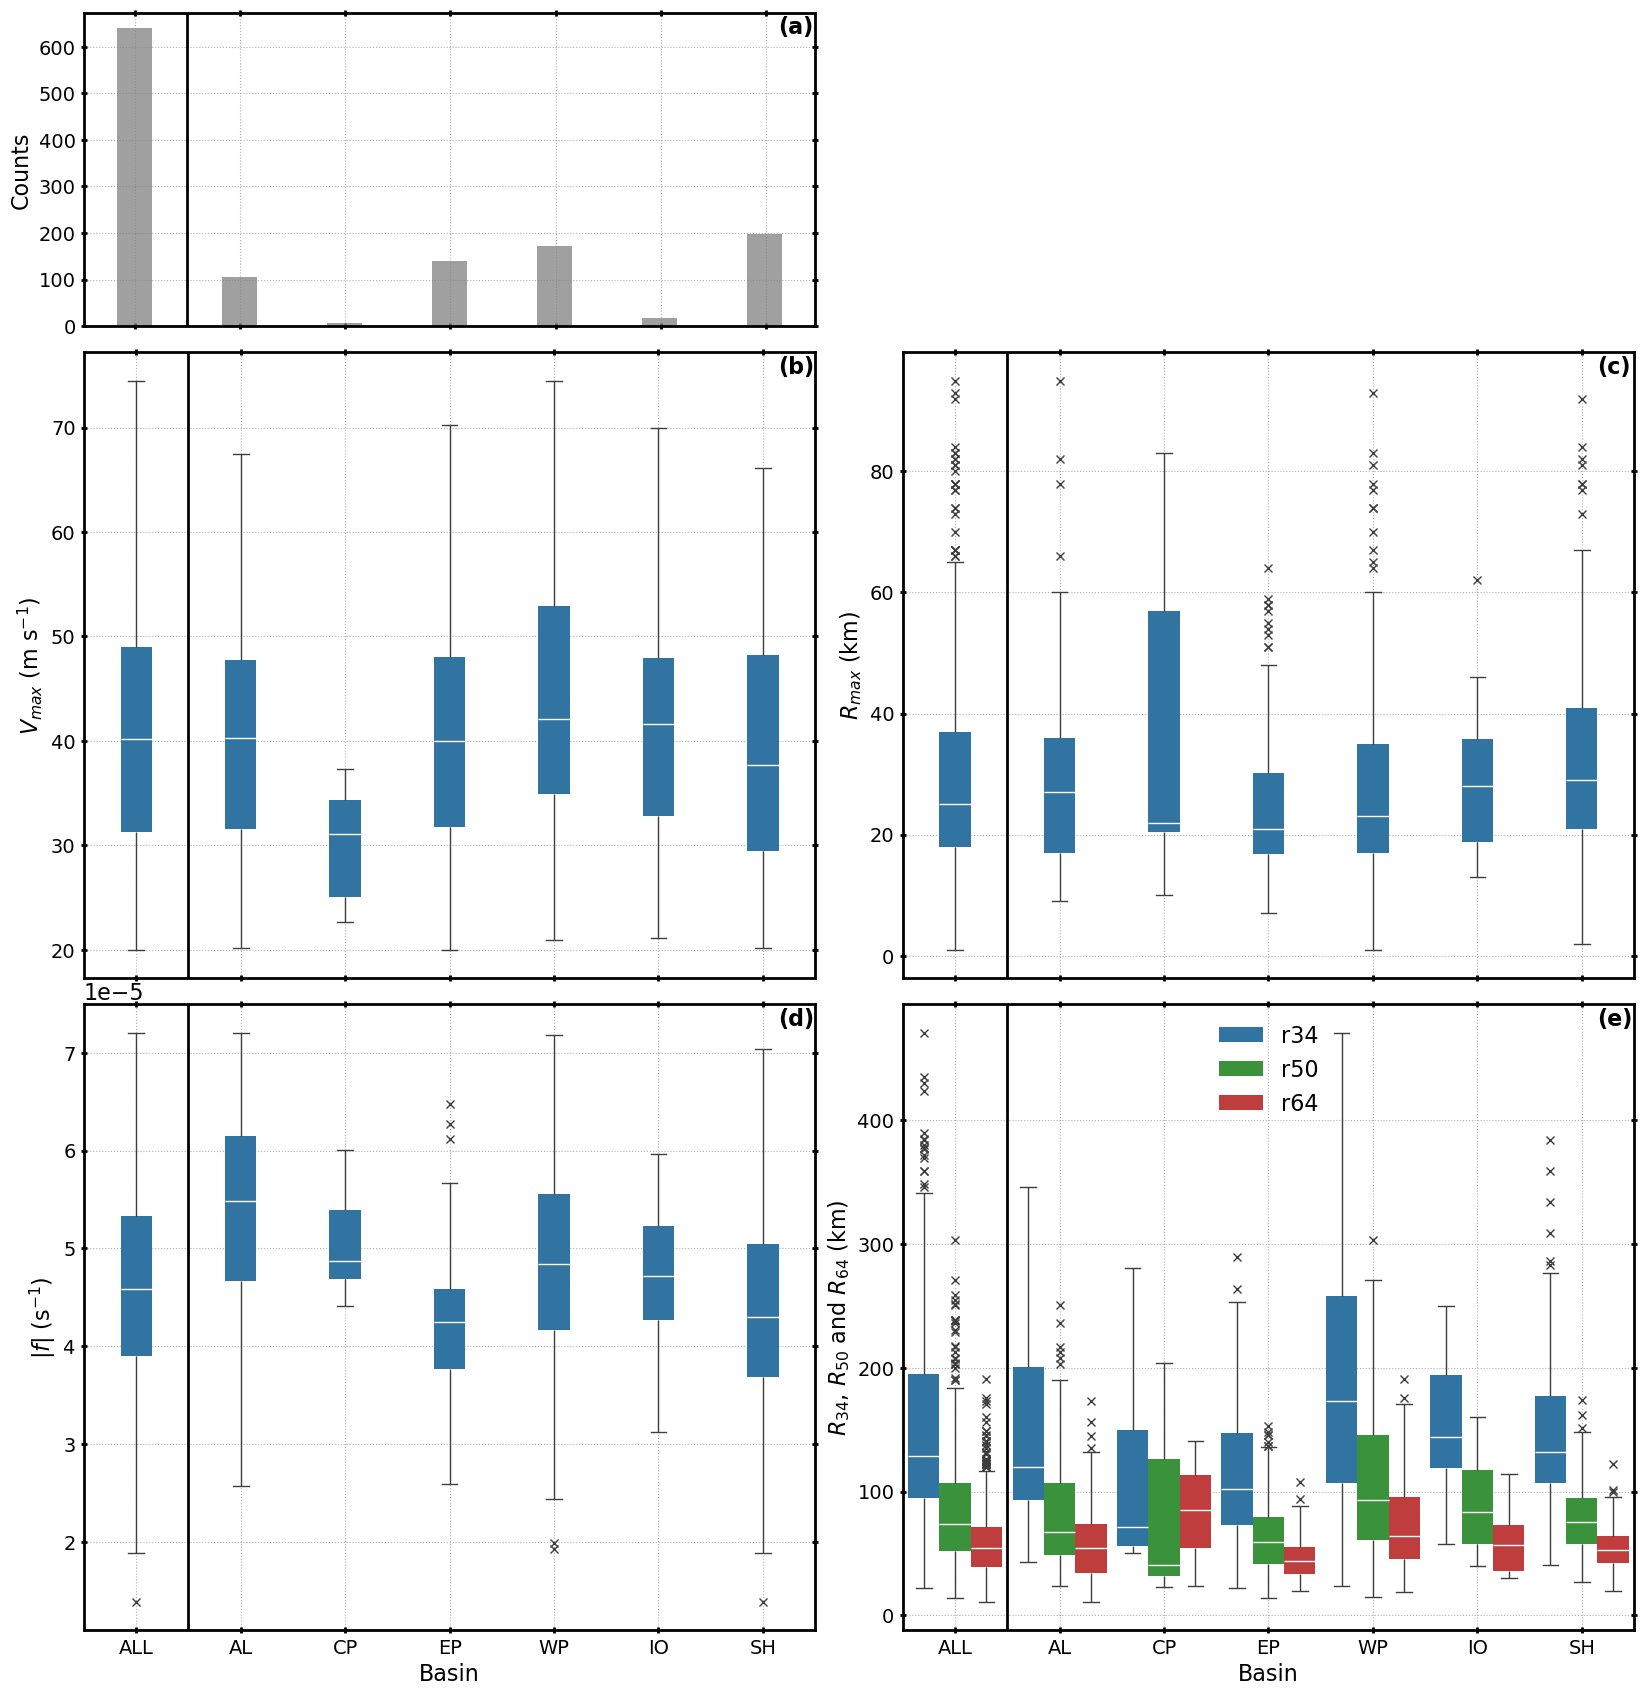

In [69]:
# Hyperparameters
width      = 0.3
bins       = np.arange(0 - width * 1.108 / 2, 6 + width * 1.108 / 2, width * 1.108)
color_glob = 'tab:blue'
color_r50  = 'tab:red'
color_r64  = 'tab:green'

# Fig.
fig        = plt.figure(figsize=(20, 21))
gs         = GridSpec(3, 2, hspace=0.05, wspace=0.12, height_ratios=[1, 2, 2])

##############
### COUNTS ###
##############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.935, '(a)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'vmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['vmx'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])

# Boxplot
g = sns.histplot(
    data=df_combined,
    x='basin_idx',
    bins=bins,
    color='grey',
    edgecolor=None,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'Counts')
# ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### VMAX ###
############
ax = fig.add_subplot(gs[1, 0])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'vmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['vmx'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'vmx': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$V_{max}$ (m s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### RMAX ###
############
ax = fig.add_subplot(gs[1, 1])
ax.text(0.95, 0.965, '(c)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'rmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['rmx'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'rmx': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$R_{max}$ (km)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### FCOR ###
############
ax = fig.add_subplot(gs[2, 0])
ax.text(0.95, 0.965, '(d)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'fcor']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['fcor'])
df_plot['value']       = abs(df_plot['value'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'fcor': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$|f|$ (s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rxx  ###
############
ax = fig.add_subplot(gs[2, 1])
ax.text(0.95, 0.965, '(e)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'r34', 'r50', 'r64']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['r34', 'r50', 'r64'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# # Code updated because it did no longer work
df_combined            = df_combined.reset_index()
# Colors
palette = {
    'r34': color_glob, 
    'r50': 'tab:green',
    'r64': 'tab:red'
}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width * 3,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$R_{34}$, $R_{50}$ and $R_{64}$ (km)')
ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

In [205]:
# # Hyperparameters
# width = 0.3

# fig        = plt.figure(figsize=(20, 20))
# gs         = GridSpec(2, 2, hspace=0.05, wspace=0.12)

# ############
# ### VMAX ###
# ############
# ax = fig.add_subplot(gs[0, 0])

# # Data pre.
# df                     = d[['basin_idx', 'vmx']].to_dataframe()
# df_plot                = df.melt(id_vars='basin_idx', value_vars=['vmx'])
# df_global              = df_plot.copy()
# df_global['basin_idx'] = 0
# df_combined            = pd.concat([df_plot, df_global])

# # Boxplot
# g = sns.boxplot(
#     x='basin_idx', 
#     y='value', 
#     hue='variable', 
#     data=df_combined, 
#     medianprops={'color': 'white'},
#     flierprops=dict(marker='x', color='grey'),
#     width=width,
# )

# # Separation for All vs. basins
# ax.axvline(0.5, c='k', linewidth=2)

# # Labels
# # xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# # g.set_xticklabels(xlabels)
# # g.set_xlabel('Basin')
# ax.set_xticklabels([])
# ax.set_xlabel('')
# g.set_ylabel(r'$V_{max}$ (m s$^{-1}$)')
# # ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# # Put the y ticks label ont the right 
# # The same can be done to put the xlabel at the top
# ax.yaxis.set_label_position("left") 
# plt.xticks(fontsize=fontsize - 2) #the x-ticks 
# plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# # Grids
# # Frame for the plot (do this after the right label position otherwise missing ticks)
# ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
# ax.spines['right'].set_linewidth(2)
# ax.spines['top'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)       
# ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
# ax.grid(ls=':')
# ax.set_axisbelow(True) # Set the grid in background

# ############
# ### RMAX ###
# ############
# ax = fig.add_subplot(gs[0, 1])

# # Data pre.
# df                     = d[['basin_idx', 'rmx']].to_dataframe()
# df_plot                = df.melt(id_vars='basin_idx', value_vars=['rmx'])
# df_plot['value']       = df_plot['value'] / 1000
# df_global              = df_plot.copy()
# df_global['basin_idx'] = 0
# df_combined            = pd.concat([df_plot, df_global])

# # Boxplot
# g = sns.boxplot(
#     x='basin_idx', 
#     y='value', 
#     hue='variable', 
#     data=df_combined, 
#     medianprops={'color': 'white'},
#     flierprops=dict(marker='x', color='grey'),
#     width=width,
# )

# # Separation for All vs. basins
# ax.axvline(0.5, c='k', linewidth=2)

# # Labels
# # xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# # g.set_xticklabels(xlabels)
# # g.set_xlabel('Basin')
# ax.set_xticklabels([])
# ax.set_xlabel('')
# g.set_ylabel(r'$R_{max}$ (km)')
# # ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# # Put the y ticks label ont the right 
# # The same can be done to put the xlabel at the top
# ax.yaxis.set_label_position("left") 
# plt.xticks(fontsize=fontsize - 2) #the x-ticks 
# plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# # Grids
# # Frame for the plot (do this after the right label position otherwise missing ticks)
# ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
# ax.spines['right'].set_linewidth(2)
# ax.spines['top'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)       
# ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
# ax.grid(ls=':')
# ax.set_axisbelow(True) # Set the grid in background

# ############
# ### FCOR ###
# ############
# ax = fig.add_subplot(gs[1, 0])

# # Data pre.
# df                     = d[['basin_idx', 'fcor']].to_dataframe()
# df_plot                = df.melt(id_vars='basin_idx', value_vars=['fcor'])
# df_plot['value']       = abs(df_plot['value'])
# df_global              = df_plot.copy()
# df_global['basin_idx'] = 0
# df_combined            = pd.concat([df_plot, df_global])

# # Boxplot
# g = sns.boxplot(
#     x='basin_idx', 
#     y='value', 
#     hue='variable', 
#     data=df_combined, 
#     medianprops={'color': 'white'},
#     flierprops=dict(marker='x', color='grey'),
#     width=width,
# )

# # Separation for All vs. basins
# ax.axvline(0.5, c='k', linewidth=2)

# # Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
# g.set_ylabel(r'$|f|$ (s$^{-1}$)')
# # ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# # Put the y ticks label ont the right 
# # The same can be done to put the xlabel at the top
# ax.yaxis.set_label_position("left") 
# plt.xticks(fontsize=fontsize - 2) #the x-ticks 
# plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# # Grids
# # Frame for the plot (do this after the right label position otherwise missing ticks)
# ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
# ax.spines['right'].set_linewidth(2)
# ax.spines['top'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)       
# ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
# ax.grid(ls=':')
# ax.set_axisbelow(True) # Set the grid in background

# ############
# ### Rxx  ###
# ############
# ax = fig.add_subplot(gs[1, 1])

# # Data pre.
# df                     = d[['basin_idx', 'r34', 'r50', 'r64']].to_dataframe()
# df_plot                = df.melt(id_vars='basin_idx', value_vars=['r34', 'r50', 'r64'])
# df_plot['value']       = df_plot['value'] / 1000
# df_global              = df_plot.copy()
# df_global['basin_idx'] = 0
# df_combined            = pd.concat([df_plot, df_global])

# # Boxplot
# g = sns.boxplot(
#     x='basin_idx', 
#     y='value', 
#     hue='variable', 
#     data=df_combined, 
#     medianprops={'color': 'white'},], dtype='datetime64[ns]')
#     flierprops=dict(marker='x', color='grey'),
#     width=width * 3,
# )

# # Separation for All vs. basins
# ax.axvline(0.5, c='k', linewidth=2)

# # Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
# g.set_ylabel(r'$R_{34}$, $R_{50}$ and $R_{64}$ (km)')
# ax.legend(frameon=False, loc='upper center')
# # ax.legend_.remove()
# # Put the y ticks label ont the right 
# # The same can be done to put the xlabel at the top
# ax.yaxis.set_label_position("left") 
# plt.xticks(fontsize=fontsize - 2) #the x-ticks 
# plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# # Grids
# # Frame for the plot (do this after the right label position otherwise missing ticks)
# ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
# ax.spines['right'].set_linewidth(2)
# ax.spines['top'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)       
# ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
# ax.grid(ls=':')
# ax.set_axisbelow(True) # Set the grid in background